In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# 데이터 경로 후보
train_candidates = [
    Path("../data/29757_train_merged.csv"),
    Path("../data/1000_train_merged.csv"),
    Path("../data/10000_train_merged.csv"),
]
test_candidates = [
    Path("../data/29757_test_merged.csv"),
    Path("../data/1000_test_merged.csv"),
    Path("../data/10000_test_merged.csv"),
]


def resolve_path(candidates: list[Path]) -> Path:
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"No dataset found in: {candidates}")


train_path = resolve_path(train_candidates)
test_path = resolve_path(test_candidates)

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

target_col = "died_in_icu"
possible_group_cols = ["patientunitstayid", "patient_id"]
possible_time_cols = ["observationoffset"]

group_col = next((c for c in possible_group_cols if c in train_df.columns), None)
time_col = next((c for c in possible_time_cols if c in train_df.columns), None)

if group_col is None or time_col is None:
    raise ValueError("patient id or time column not found")

# base feature: 숫자형 + 타깃/ID만 제외 (time_col은 포함)
numeric_cols = train_df.select_dtypes(include=["number"]).columns

exclude = {
    target_col,          # died_in_icu
    "patient_id",
    "patientunitstayid",
}  # time_col(observationoffset)은 제외하지 않음

base_cols = [c for c in numeric_cols if c not in exclude]




def add_missing_and_time_features(df: pd.DataFrame, base_cols: list[str]) -> pd.DataFrame:
    df = df.sort_values([group_col, time_col]).copy()

    for col in base_cols:
        miss = df[col].isna().astype(int)
        last_time = df[time_col].where(df[col].notna()).groupby(df[group_col]).ffill()
        tsince = df[time_col] - last_time
        tsince = tsince.fillna(df[time_col])  # 첫 측정 전 구간은 입실 후 경과시간으로 대체

        df[f"{col}_miss"] = miss
        df[f"{col}_tsince"] = tsince

    return df


def impute_base(df: pd.DataFrame, base_cols: list[str], medians: pd.Series) -> pd.DataFrame:
    df = df.sort_values([group_col, time_col]).copy()
    df[base_cols] = df.groupby(group_col, sort=False)[base_cols].ffill()
    df[base_cols] = df[base_cols].fillna(medians)
    return df

# 결측치 처리(훈련 기준 중앙값)
train_medians = train_df[base_cols].median()

train_proc = add_missing_and_time_features(train_df, base_cols)
test_proc = add_missing_and_time_features(test_df, base_cols)

train_proc = impute_base(train_proc, base_cols, train_medians)
test_proc = impute_base(test_proc, base_cols, train_medians)

feature_cols = (
    base_cols
    + [f"{c}_miss" for c in base_cols]
    + [f"{c}_tsince" for c in base_cols]
)
# stayid별 최대 10개 샘플로 축소 + 92:8 클래스 비율 맞추기 (train만)
def sample_k_per_stay(df, group_col, time_col, k=10, random_state=42):
    df = df.sort_values([group_col, time_col]).copy()

    def pick_rows(g):
        n = len(g)
        if n <= k:
            return g
        # 균등 간격으로 k개 선택
        idx = np.linspace(0, n - 1, k, dtype=int)
        return g.iloc[idx]

    return df.groupby(group_col, group_keys=False).apply(pick_rows)


def balance_ratio(df, target_col="died_in_icu", ratio_pos=0.08, random_state=42):
    # ratio_pos = 사망 비율 (0.08)
    pos = df[df[target_col] == 1]
    neg = df[df[target_col] == 0]

    # pos가 적으면 neg를 줄여서 맞춤
    desired_neg = int(len(pos) * (1 - ratio_pos) / ratio_pos)

    if desired_neg >= len(neg):
        # neg가 부족하면 pos를 줄여서 맞춤
        desired_pos = int(len(neg) * ratio_pos / (1 - ratio_pos))
        pos = pos.sample(n=desired_pos, random_state=random_state)
    else:
        neg = neg.sample(n=desired_neg, random_state=random_state)

    out = pd.concat([pos, neg]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return out







In [2]:
# 1) stayid별 최대 10개로 축소
train_proc = sample_k_per_stay(train_proc, group_col, time_col, k=10)
test_proc = sample_k_per_stay(test_proc, group_col, time_col, k=10)

# 2) 클래스 비율 92:8로 맞추기 (train만)
train_proc = balance_ratio(train_proc, target_col=target_col, ratio_pos=0.08)
test_proc = balance_ratio(test_proc, target_col=target_col, ratio_pos=0.08)
# feature/label 다시 구성
X_train = train_proc[feature_cols]
y_train = train_proc[target_col]

# test는 그대로
X_test = test_proc[feature_cols]
y_test = test_proc[target_col]

/var/folders/6v/1_79rvdd7kn_cz07rmxph3p40000gn/T/ipykernel_3569/722237191.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(pick_rows)
/var/folders/6v/1_79rvdd7kn_cz07rmxph3p40000gn/T/ipykernel_3569/722237191.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(pick_rows)


In [3]:
# SMOTE로 불균형 처리 (train만)
# 필요: pip install imbalanced-learn (또는 uv add imbalanced-learn)
from imblearn.over_sampling import SMOTE

# 학습 데이터만 SMOTE 적용
smote = SMOTE(sampling_strategy=0.5 / 0.5, random_state=42, k_neighbors=5)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = smote.fit_resample(X_test, y_test) 
print("before:", y_train.value_counts(normalize=True))
print("after :", pd.Series(y_train_sm).value_counts(normalize=True))

# 이후 모델 학습에 X_train_sm, y_train_sm 사용


before: died_in_icu
0    0.92
1    0.08
Name: proportion, dtype: float64
after : died_in_icu
0    0.5
1    0.5
Name: proportion, dtype: float64


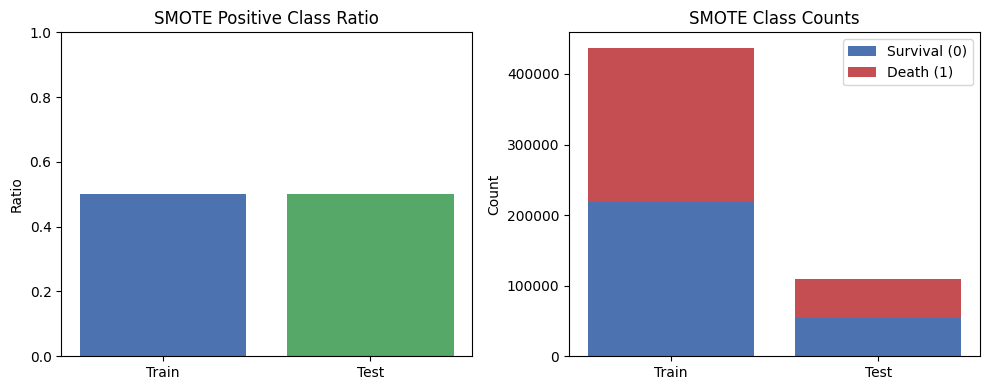

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_ratio_y(y_train, y_test, title_prefix=""):
    sets = ["Train", "Test"]
    ys = [np.array(y_train), np.array(y_test)]

    ratios = [y.mean() for y in ys]
    counts_pos = [y.sum() for y in ys]
    counts_neg = [len(y) - p for y, p in zip(ys, counts_pos)]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].bar(sets, ratios, color=["#4C72B0", "#55A868"])
    axes[0].set_title(f"{title_prefix} Positive Class Ratio")
    axes[0].set_ylabel("Ratio")
    axes[0].set_ylim(0, 1)

    x = range(len(sets))
    axes[1].bar(x, counts_neg, label="Survival (0)", color="#4C72B0")
    axes[1].bar(x, counts_pos, bottom=counts_neg, label="Death (1)", color="#C44E52")
    axes[1].set_xticks(list(x))
    axes[1].set_xticklabels(sets)
    axes[1].set_title(f"{title_prefix} Class Counts")
    axes[1].set_ylabel("Count")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_class_ratio_y(y_train_sm, y_test_sm, title_prefix="SMOTE")


## 데이터 누수 확인

In [25]:
from sklearn.metrics import roc_auc_score


# 단일 피처 AUC 계산(샘플링해서 빠르게)
sample_df = train_df[[target_col] + base_cols].dropna(subset=[target_col]).sample(
    min(200000, len(train_df)), random_state=42
)

aucs = []
y = sample_df[target_col].values
for c in base_cols:
    x = sample_df[c].values
    if np.nanstd(x) == 0:
        continue
    # NaN은 임시로 중앙값
    x = np.where(np.isnan(x), np.nanmedian(x), x)
    try:
        aucs.append((c, roc_auc_score(y, x)))
    except Exception:
        pass

aucs = sorted(aucs, key=lambda t: t[1], reverse=True)[:30]
print(pd.DataFrame(aucs, columns=["col","auc"]))

                  col       auc
0            feature4  0.587475
1            feature3  0.581432
2   observationoffset  0.576717
3            feature1  0.575774
4           feature12  0.523220
5           feature35  0.513896
6           feature21  0.511855
7           feature29  0.509148
8           feature31  0.506691
9           feature15  0.505019
10          feature18  0.504460
11          feature13  0.503876
12          feature22  0.503844
13          feature16  0.503323
14          feature17  0.502900
15          feature34  0.500000
16          feature30  0.499844
17          feature19  0.499732
18          feature28  0.499692
19          feature14  0.499489
20          feature24  0.498159
21          feature26  0.496455
22          feature23  0.496304
23          feature32  0.495428
24          feature33  0.494829
25          feature27  0.492369
26          feature20  0.492290
27           feature7  0.487108
28          feature25  0.487019
29          feature11  0.479178


In [26]:
train_p = set(train_df[group_col].unique())
test_p  = set(test_df[group_col].unique())
overlap = train_p & test_p
print("overlap patients:", len(overlap))

overlap patients: 0


## 모델 학습

In [7]:
models: dict[str, object] = {
    "LR": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000)),
    ]),
    "RF": RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced",
    ),
}

try:
    import xgboost as xgb
    models["XGBoost"] = xgb.XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    )
except Exception:
    pass

try:
    import lightgbm as lgb
    models["LightGBM"] = lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
    )
except Exception:
    pass


def aggregate_patient_scores(df: pd.DataFrame, scores: np.ndarray):
    tmp = df[[group_col, target_col]].copy()
    tmp["score"] = scores
    y_patient = tmp.groupby(group_col)[target_col].max()
    s_patient = tmp.groupby(group_col)["score"].mean()
    return y_patient, s_patient


pred_scores = {}

for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)

    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test_sm)[:, 1]
    else:
        raw = model.decision_function(X_test_sm)
        scores = 1 / (1 + np.exp(-raw))

    pred_scores[name] = scores

print("models used:", list(pred_scores.keys()))
print("test_smote n:", len(y_test_sm))


[LightGBM] [Info] Number of positive: 218569, number of negative: 218569
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17755
[LightGBM] [Info] Number of data points in the train set: 437138, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
models used: ['LR', 'RF', 'XGBoost', 'LightGBM']
test_smote n: 109318


# ROC + Calibration + Decision Curve 시각화

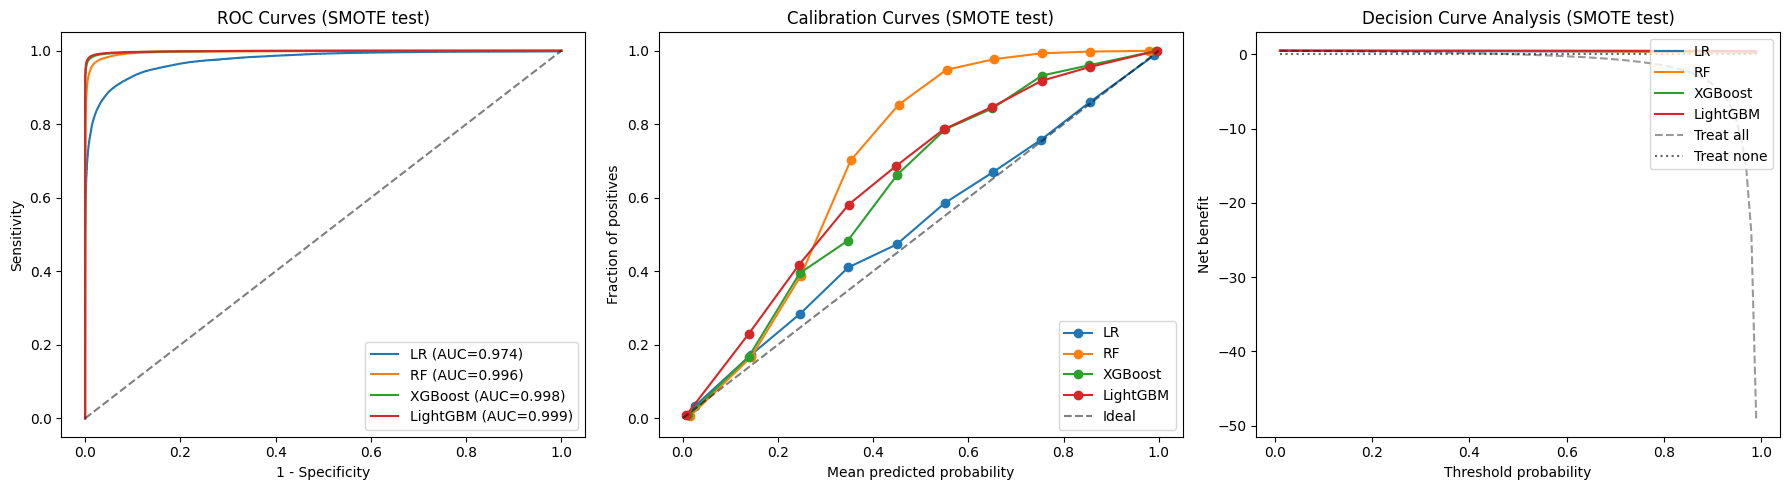

In [8]:
# 시각화: ROC + Calibration + Decision Curve (SMOTE test 기준, row-level)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) ROC
ax = axes[0]
for name, scores in pred_scores.items():
    fpr, tpr, _ = roc_curve(y_test_sm, scores)
    auc = roc_auc_score(y_test_sm, scores)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
ax.plot([0, 1], [0, 1], "k--", alpha=0.5)
ax.set_xlabel("1 - Specificity")
ax.set_ylabel("Sensitivity")
ax.set_title("ROC Curves (SMOTE test)")
ax.legend(loc="lower right")

# 2) Calibration
ax = axes[1]
for name, scores in pred_scores.items():
    prob_true, prob_pred = calibration_curve(y_test_sm, scores, n_bins=10, strategy="uniform")
    ax.plot(prob_pred, prob_true, marker="o", label=name)
ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Ideal")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.set_title("Calibration Curves (SMOTE test)")
ax.legend(loc="lower right")

# 3) Decision Curve
ax = axes[2]
thresholds = np.linspace(0.01, 0.99, 99)

def decision_curve(y_true, scores):
    n = len(y_true)
    net_benefit = []
    for t in thresholds:
        preds = scores >= t
        tp = ((preds == 1) & (y_true == 1)).sum()
        fp = ((preds == 1) & (y_true == 0)).sum()
        nb = (tp / n) - (fp / n) * (t / (1 - t))
        net_benefit.append(nb)
    return np.array(net_benefit)

for name, scores in pred_scores.items():
    nb = decision_curve(np.array(y_test_sm), scores)
    ax.plot(thresholds, nb, label=name)

prevalence = np.mean(y_test_sm)
nb_all = prevalence - (1 - prevalence) * (thresholds / (1 - thresholds))
ax.plot(thresholds, nb_all, "k--", alpha=0.4, label="Treat all")
ax.plot(thresholds, np.zeros_like(thresholds), "k:", alpha=0.6, label="Treat none")

ax.set_xlabel("Threshold probability")
ax.set_ylabel("Net benefit")
ax.set_title("Decision Curve Analysis (SMOTE test)")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


## Confusion matrix 시각화

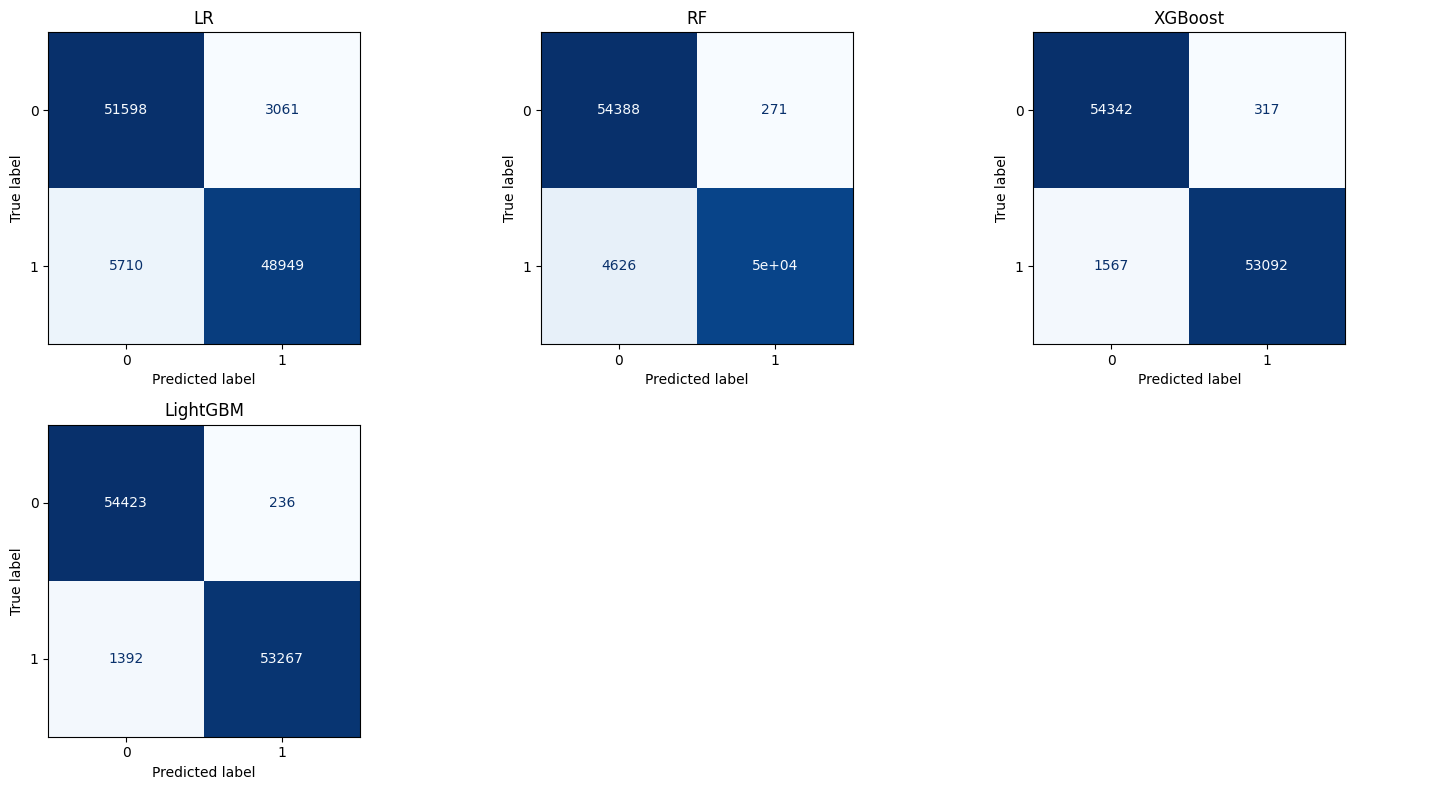

In [9]:
# Confusion Matrix 서브플롯 (환자 단위 집계 기준)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math
import numpy as np

n_models = len(pred_scores)
n_cols = 3
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = np.array(axes).reshape(-1)

for ax, (name, scores) in zip(axes, pred_scores.items()):
    y_pred = (scores >= 0.5).astype(int)
    cm = confusion_matrix(y_test_sm, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{name}")

for ax in axes[n_models:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


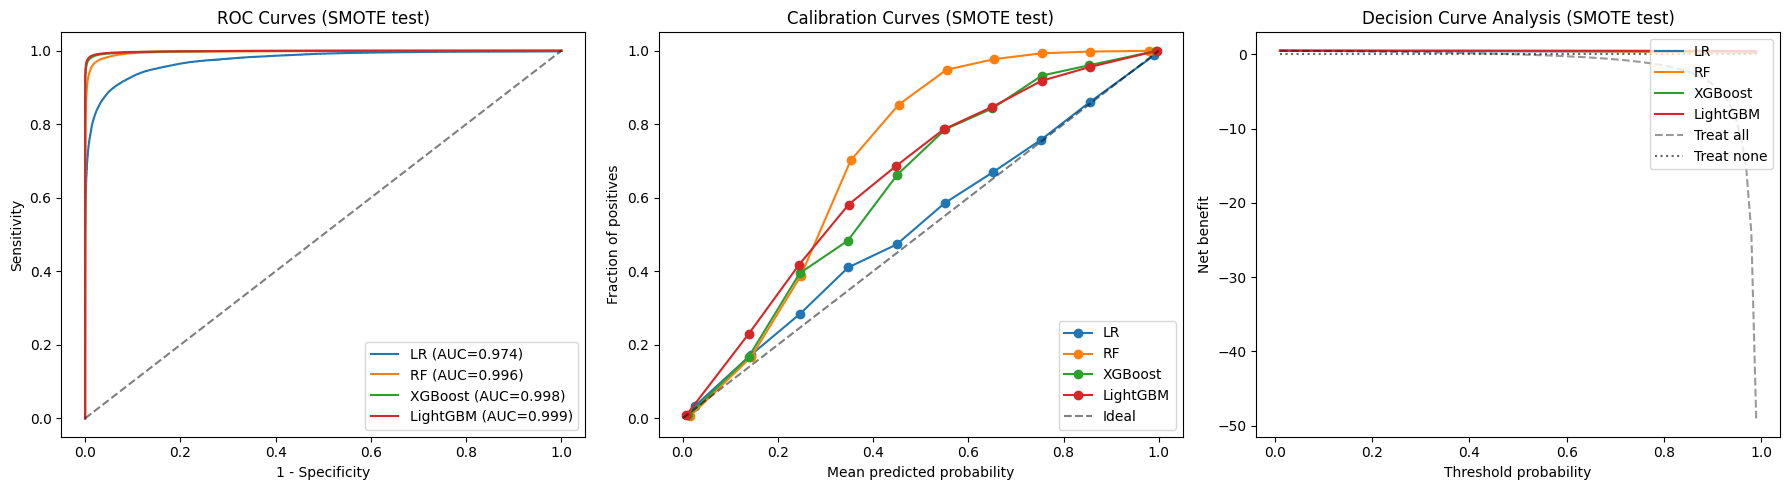

In [11]:
# 시각화: ROC + Calibration + Decision Curve (SMOTE test 기준, row-level)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) ROC
ax = axes[0]
for name, scores in pred_scores.items():
    fpr, tpr, _ = roc_curve(y_test_sm, scores)
    auc = roc_auc_score(y_test_sm, scores)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
ax.plot([0, 1], [0, 1], "k--", alpha=0.5)
ax.set_xlabel("1 - Specificity")
ax.set_ylabel("Sensitivity")
ax.set_title("ROC Curves (SMOTE test)")
ax.legend(loc="lower right")

# 2) Calibration
ax = axes[1]
for name, scores in pred_scores.items():
    prob_true, prob_pred = calibration_curve(y_test_sm, scores, n_bins=10, strategy="uniform")
    ax.plot(prob_pred, prob_true, marker="o", label=name)
ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Ideal")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.set_title("Calibration Curves (SMOTE test)")
ax.legend(loc="lower right")

# 3) Decision Curve
ax = axes[2]
thresholds = np.linspace(0.01, 0.99, 99)

def decision_curve(y_true, scores):
    n = len(y_true)
    net_benefit = []
    for t in thresholds:
        preds = scores >= t
        tp = ((preds == 1) & (y_true == 1)).sum()
        fp = ((preds == 1) & (y_true == 0)).sum()
        nb = (tp / n) - (fp / n) * (t / (1 - t))
        net_benefit.append(nb)
    return np.array(net_benefit)

for name, scores in pred_scores.items():
    nb = decision_curve(np.array(y_test_sm), scores)
    ax.plot(thresholds, nb, label=name)

prevalence = np.mean(y_test_sm)
nb_all = prevalence - (1 - prevalence) * (thresholds / (1 - thresholds))
ax.plot(thresholds, nb_all, "k--", alpha=0.4, label="Treat all")
ax.plot(thresholds, np.zeros_like(thresholds), "k:", alpha=0.6, label="Treat none")

ax.set_xlabel("Threshold probability")
ax.set_ylabel("Net benefit")
ax.set_title("Decision Curve Analysis (SMOTE test)")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [29]:
for name, scores in pred_scores_patient.items():
    print(name, len(scores))
    break

LR 7355


In [30]:
print("N_rows(test_proc):", len(test_proc))
print("N_patients(test_proc):", test_proc["patient_id"].nunique())
print("len(y_patient):", len(y_patient))

N_rows(test_proc): 1217973
N_patients(test_proc): 5950
len(y_patient): 7355


In [12]:
from __future__ import annotations

import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

def evaluate_row_level(
    pred_scores: dict[str, np.ndarray | pd.Series],
    y_true: np.ndarray | pd.Series,
    threshold: float = 0.5,
) -> pd.DataFrame:
    """
    row-level 성능 평가 (SMOTE test 기준)
    """
    y_true = np.asarray(y_true).astype(int)

    results = []
    for name, scores in pred_scores.items():
        y_score = np.asarray(scores).astype(float)
        y_pred = (y_score >= threshold).astype(int)

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        if np.unique(y_true).size < 2:
            auc = np.nan
            ap = np.nan
        else:
            auc = roc_auc_score(y_true, y_score)
            ap = average_precision_score(y_true, y_score)

        results.append({
            "model": name,
            "N_rows": len(y_true),
            "pos_rate": float(y_true.mean()),
            "threshold": threshold,
            "ACC": acc,
            "PREC": prec,
            "REC": rec,
            "F1": f1,
            "AUC": auc,
            "PR-AUC": ap,
        })

    out = (
        pd.DataFrame(results)
        .set_index("model")
        .sort_values(["PR-AUC", "AUC"], ascending=False)
    )
    return out


# 실행 (SMOTE test 기준)
metrics_df = evaluate_row_level(
    pred_scores=pred_scores,
    y_true=y_test_sm,
    threshold=0.5
)

print(metrics_df.to_string(float_format=lambda x: f"{x:.4f}"))


          N_rows  pos_rate  threshold    ACC   PREC    REC     F1    AUC  PR-AUC
model                                                                           
LightGBM  109318    0.5000     0.5000 0.9851 0.9956 0.9745 0.9849 0.9986  0.9988
XGBoost   109318    0.5000     0.5000 0.9828 0.9941 0.9713 0.9826 0.9984  0.9986
RF        109318    0.5000     0.5000 0.9552 0.9946 0.9154 0.9533 0.9962  0.9965
LR        109318    0.5000     0.5000 0.9198 0.9411 0.8955 0.9178 0.9739  0.9780


## SHAP 분석 (모델별)

/Users/ijaeyong/Desktop/Oracle_BC/mini_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP failed for LR: property 'feature_names_in_' of 'Pipeline' object has no setter
SHAP failed for RF: Data must be 1-dimensional, got ndarray of shape (111, 2) instead

XGBoost Top 30 features:
feature9            0.625528
feature10           0.545100
feature8            0.424175
feature8_tsince     0.409283
feature14_tsince    0.357553
feature5_tsince     0.305966
feature2            0.302242
feature8_miss       0.283789
feature1            0.279345
feature25           0.273250
feature11           0.271475
feature7_tsince     0.259289
feature31           0.251946
feature4_miss       0.243921
feature32_tsince    0.239228
feature3_tsince     0.238176
feature5_miss       0.236631
feature3            0.230149
feature14           0.228240
feature3_miss       0.225788
feature7_miss       0.225704
feature5            0.219989
feature12           0.207009
feature4            0.193786
feature4_tsince     0.189981
feature21           0.188518
feature20           0.170753
feature12_tsince    0

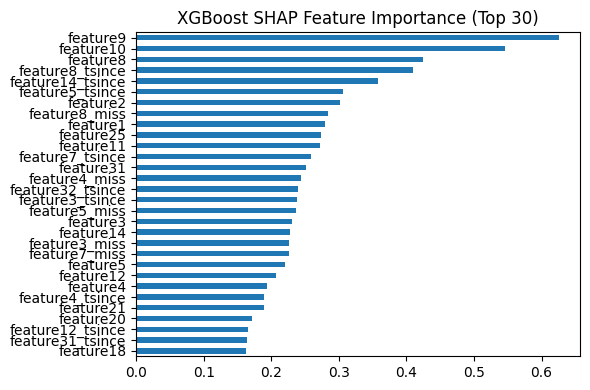

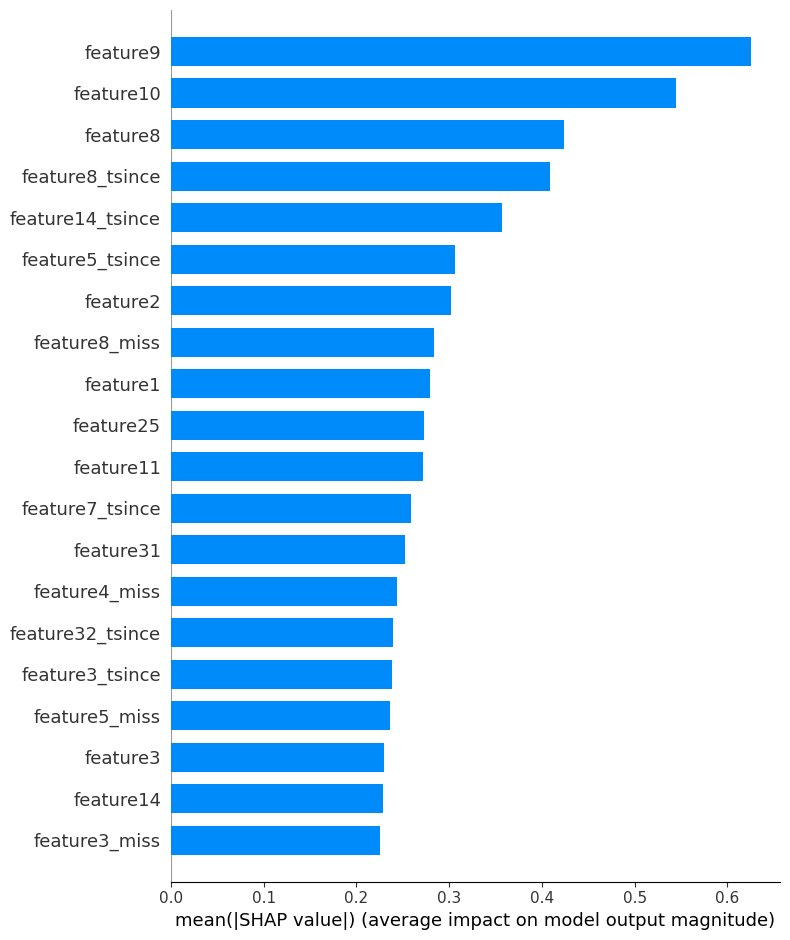

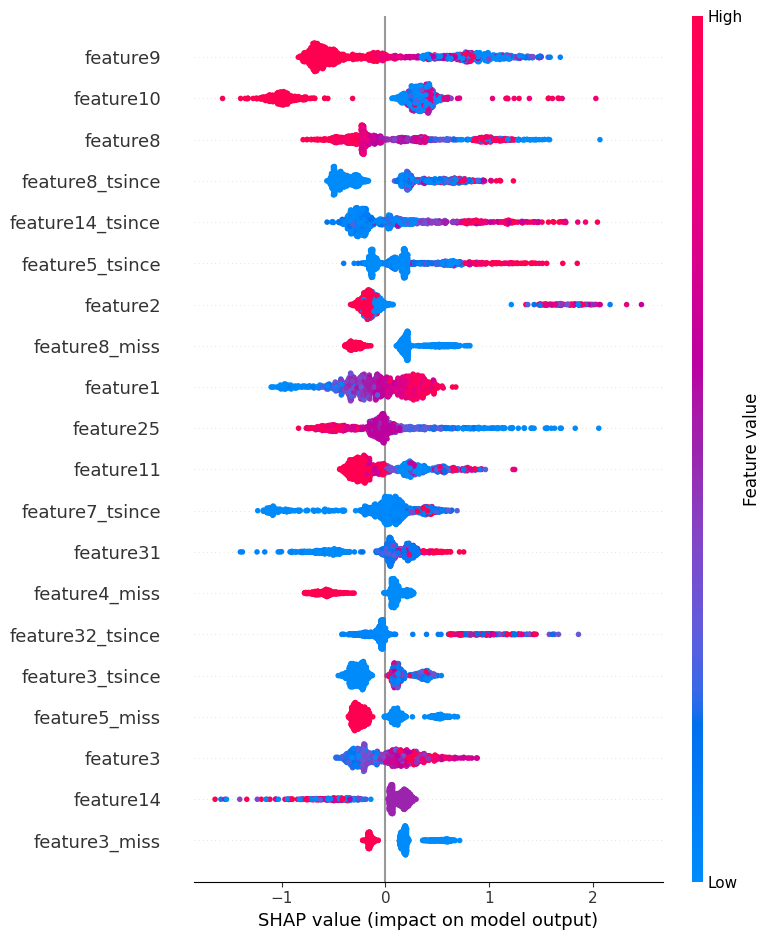


LightGBM Top 30 features:
feature9            0.738120
feature10           0.625083
feature8_tsince     0.504914
feature8            0.450710
feature14_tsince    0.391165
feature8_miss       0.380650
feature32_tsince    0.372683
feature2            0.364002
feature11           0.354106
feature14           0.337748
feature1            0.334679
feature31           0.317064
feature12_miss      0.294566
feature3            0.292344
feature25           0.288967
feature7_tsince     0.286872
feature7_miss       0.284673
feature5_tsince     0.275740
feature5            0.270608
feature18           0.263499
feature12_tsince    0.250222
feature3_tsince     0.239728
feature3_miss       0.231505
feature19_tsince    0.223588
feature4            0.222636
feature21           0.219289
feature20           0.218439
feature26           0.207551
feature31_tsince    0.202248
feature12           0.199086
dtype: float64


/Users/ijaeyong/Desktop/Oracle_BC/mini_project/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


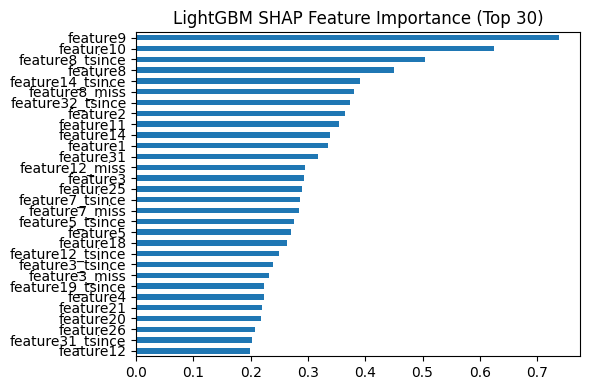

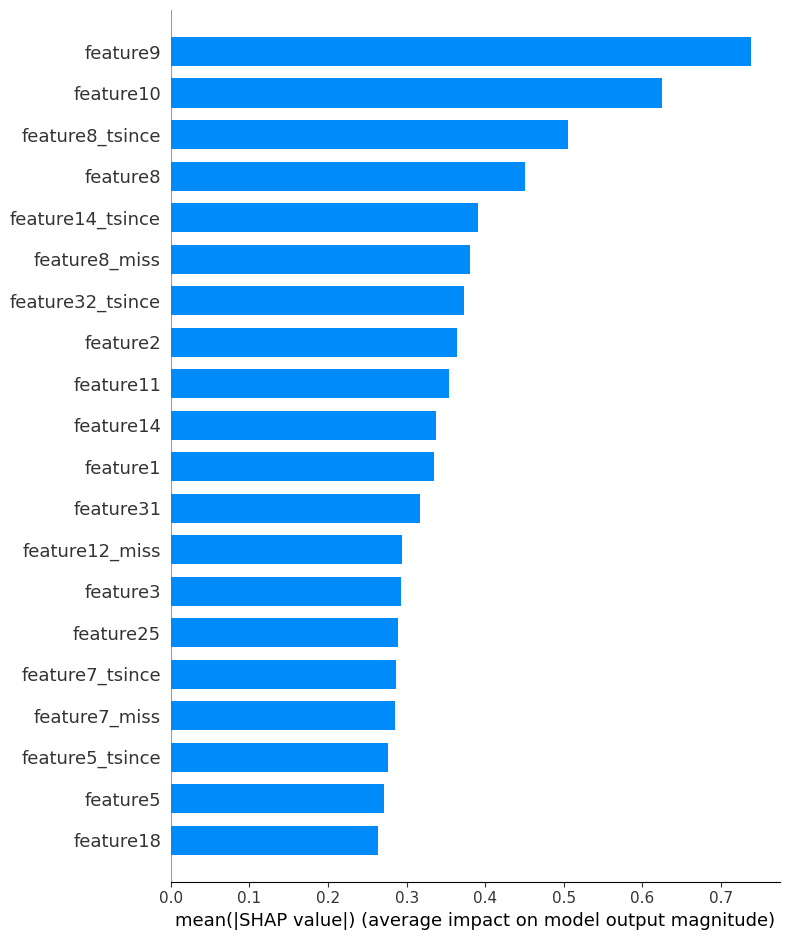

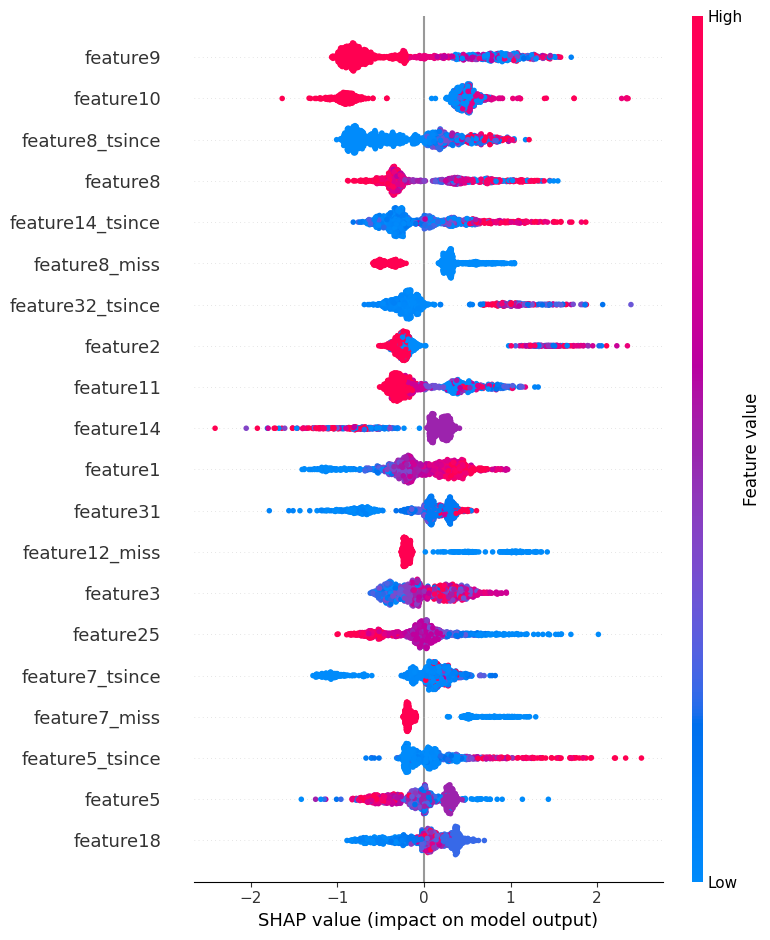

In [13]:
# SHAP 분석 + 중요 피처 Top-N (SMOTE 환경용)
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SMOTE test 기준으로 SHAP
X_shap = pd.DataFrame(X_test_sm, columns=X_train.columns).sample(
    n=min(1000, len(X_test_sm)), random_state=42
)
top_n = 30

for name, model in models.items():
    try:
        if name in ["RF", "XGBoost", "LightGBM"]:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_shap)
        else:
            bg = X_shap.sample(100, random_state=42)
            explainer = shap.KernelExplainer(model.predict_proba, bg)
            shap_values = explainer.shap_values(X_shap, nsamples=100)

        if isinstance(shap_values, list) and len(shap_values) > 1:
            sv = shap_values[1]
        else:
            sv = shap_values

        mean_abs = np.abs(sv).mean(axis=0)
        imp = pd.Series(mean_abs, index=X_shap.columns).sort_values(ascending=False)

        print(f"\n{name} Top {top_n} features:")
        print(imp.head(top_n))

        plt.figure(figsize=(6, 4))
        imp.head(top_n).sort_values().plot(kind="barh")
        plt.title(f"{name} SHAP Feature Importance (Top {top_n})")
        plt.tight_layout()
        plt.show()

        shap.summary_plot(sv, X_shap, show=True, plot_type="bar")
        shap.summary_plot(sv, X_shap, show=True)
    except Exception as e:
        print(f"SHAP failed for {name}: {e}")


(ML)
전처리 전 feature 별 Missing Value rate & ratio

전처리 후 Model -> Shap[Important Feature] MIN, MAX, MEDIAN, MEAN)

,missing_count,missing_rate,missing_rate_pct,missing_ratio
feature34,4868421,0.999970,99.996981,33118.510204
feature30,4867595,0.999800,99.980015,5002.667009
feature14,4842196,0.994583,99.458321,183.611254
feature28,4827069,0.991476,99.147614,116.317718
feature16,4816094,0.989222,98.922188,91.780577
feature13,4815977,0.989198,98.919785,91.574167
feature17,4815439,0.989087,98.908735,90.636733
feature15,4815243,0.989047,98.904709,90.299916
feature31,4745424,0.974706,97.470632,38.535568
feature32,4688780,0.963072,96.307169,26.079494


,missing_count,missing_rate,missing_rate_pct,missing_ratio
feature19,4686698,0.962644,96.264405,25.769495
feature23,4684893,0.962273,96.227330,25.506427
feature27,4680265,0.961323,96.132271,24.854968
feature26,4678775,0.961017,96.101667,24.651989
feature22,4672879,0.959806,95.980563,23.879109
feature18,4668033,0.958810,95.881027,23.277897
feature21,4667044,0.958607,95.860713,23.158750
feature25,4667030,0.958604,95.860425,23.157072
feature24,4660849,0.957335,95.733468,22.438241
feature20,4657164,0.956578,95.657779,22.029687


,missing_count,missing_rate,missing_rate_pct,missing_ratio
feature33,4654916,0.956116,95.611605,21.787374
feature29,4652073,0.955532,95.553210,21.488131
feature12,4427637,0.909433,90.943312,10.041564
feature9,4146529,0.851694,85.169376,5.742805
feature10,4144857,0.851350,85.135034,5.727227
feature11,4143657,0.851104,85.110386,5.716091
feature7,4005447,0.822716,82.271563,4.640655
feature6,3059346,0.628387,62.838724,1.690973
feature5,3055159,0.627527,62.752723,1.684760
feature8,1852504,0.380503,38.050285,0.614212


,missing_count,missing_rate,missing_rate_pct,missing_ratio
feature3,1834908,0.376889,37.688865,0.604850
feature4,1796512,0.369002,36.900214,0.584791
feature36,212972,0.043744,4.374428,0.045745
feature35,21590,0.004435,0.443457,0.004454
patientunitstayid,0,0.000000,0.000000,0.000000
died_in_icu,0,0.000000,0.000000,0.000000
feature2,0,0.000000,0.000000,0.000000
feature1,0,0.000000,0.000000,0.000000
observationoffset,0,0.000000,0.000000,0.000000
patient_id,0,0.000000,0.000000,0.000000


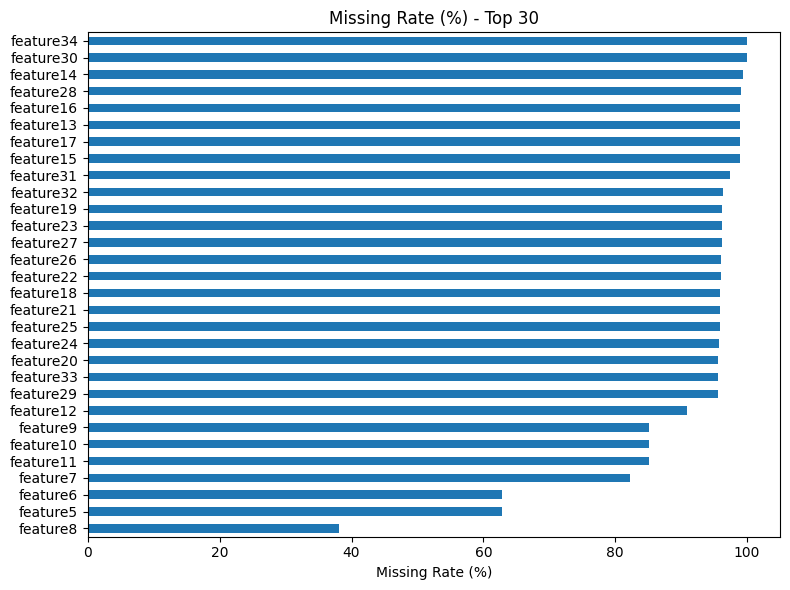

,died_in_icu=0,died_in_icu=1
feature34,0.999969,1.000000
feature30,0.999800,0.999824
feature14,0.994614,0.992728
feature28,0.991521,0.988797
feature16,0.989344,0.981864
feature13,0.989315,0.982153
feature17,0.989208,0.981814
feature15,0.989158,0.982379
feature31,0.974797,0.969241
feature32,0.963118,0.960261


,died_in_icu=0,died_in_icu=1
feature19,0.962722,0.957938
feature23,0.962317,0.959658
feature27,0.961938,0.924303
feature26,0.961633,0.923939
feature22,0.959889,0.954810
feature18,0.958849,0.956493
feature21,0.958650,0.956004
feature25,0.958677,0.954245
feature24,0.957340,0.957021
feature20,0.956631,0.953404


,died_in_icu=0,died_in_icu=1
feature33,0.956173,0.952675
feature29,0.955581,0.952612
feature12,0.909991,0.875873
feature9,0.851138,0.885117
feature10,0.850799,0.884539
feature11,0.850555,0.884125
feature7,0.822671,0.825408
feature6,0.626045,0.769292
feature5,0.625205,0.767194
feature8,0.379612,0.434074


,died_in_icu=0,died_in_icu=1
feature3,0.377125,0.362673
feature4,0.369514,0.338194
feature36,0.044206,0.015963
feature35,0.004496,0.000741
patientunitstayid,0.000000,0.000000
died_in_icu,0.000000,0.000000
feature2,0.000000,0.000000
feature1,0.000000,0.000000
observationoffset,0.000000,0.000000
patient_id,0.000000,0.000000


<Figure size 1000x600 with 0 Axes>

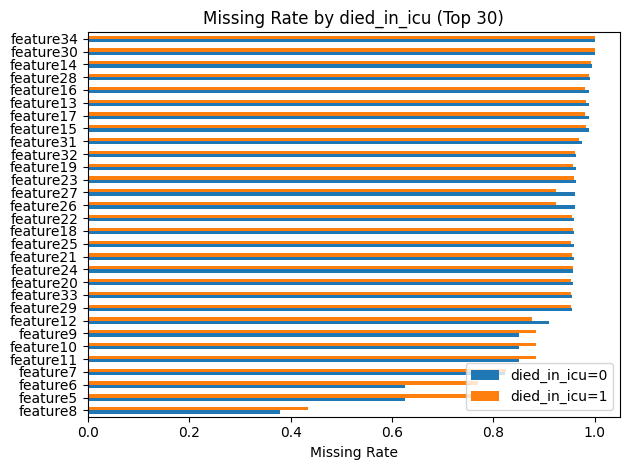

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====== (1) 전처리 전 feature별 Missing Value rate & ratio ======
def missing_report(df):
    total = len(df)
    missing_cnt = df.isna().sum()
    missing_rate = missing_cnt / total
    # ratio = missing / non-missing
    non_missing_cnt = total - missing_cnt
    missing_ratio = missing_cnt / non_missing_cnt.replace(0, np.nan)

    report = pd.DataFrame({
        "missing_count": missing_cnt,
        "missing_rate": missing_rate,        # 0~1
        "missing_rate_pct": missing_rate * 100,
        "missing_ratio": missing_ratio       # missing / non-missing
    }).sort_values("missing_rate", ascending=False)

    return report

# ====== (2) 사망/생존(타깃)별 Missing Value rate ======
def missing_report_by_target(df, target_col):
    total = df.groupby(target_col).size()
    missing_cnt = df.isna().groupby(df[target_col]).sum()
    missing_rate = missing_cnt.div(total, axis=0)

    # 컬럼별 정렬 (전체 결측률 기준)
    overall_rate = df.isna().mean().sort_values(ascending=False)
    missing_cnt = missing_cnt[overall_rate.index]
    missing_rate = missing_rate[overall_rate.index]

    return missing_cnt, missing_rate

# ====== (3) 10개씩 끊어서 출력 ======
def display_in_chunks(df, chunk_size=10):
    for i in range(0, len(df), chunk_size):
        display(df.iloc[i:i+chunk_size])

# ====== 실행 예시 ======
df_raw = train_df  # 전처리 전 데이터프레임
target_col = "died_in_icu"  # 타깃 컬럼명

# (1) 전체 결측 리포트
missing_report_df = missing_report(df_raw)
display_in_chunks(missing_report_df, chunk_size=10)

plt.figure(figsize=(8, 6))
missing_report_df["missing_rate_pct"].head(30).sort_values().plot(kind="barh")
plt.title("Missing Rate (%) - Top 30")
plt.xlabel("Missing Rate (%)")
plt.tight_layout()
plt.show()

# (2) 타깃별 결측 리포트
missing_cnt_by_t, missing_rate_by_t = missing_report_by_target(df_raw, target_col)

# 보기 좋게 전치: index=feature, columns=target class
missing_rate_by_t_T = missing_rate_by_t.T
missing_rate_by_t_T.columns = [f"{target_col}={c}" for c in missing_rate_by_t_T.columns]

display_in_chunks(missing_rate_by_t_T, chunk_size=10)

# 시각화: 타깃별 결측률 (Top 30)
plt.figure(figsize=(10, 6))
missing_rate_by_t_T.head(30).sort_values(by=missing_rate_by_t_T.columns[0]).plot(kind="barh")
plt.title(f"Missing Rate by {target_col} (Top 30)")
plt.xlabel("Missing Rate")
plt.tight_layout()
plt.show()


In [31]:
import numpy as np
import pandas as pd

def print_feature_summaries_by_target(df, features, target_col, max_cat=15):
    """
    df: 데이터프레임
    features: 볼 피처 목록(list)
    target_col: 사망/생존 라벨 컬럼명
    max_cat: 범주형일 때 상위 몇 개 카테고리까지 표시
    """
    valid_feats = [f for f in features if f in df.columns]
    if target_col not in df.columns:
        print(f"{target_col} not in df")
        return
    if not valid_feats:
        print("No valid features.")
        return

    for col in valid_feats:
        print(f"\n[{col}]")
        s = df[col]

        if pd.api.types.is_numeric_dtype(s):
            stats_by_class = df.groupby(target_col)[col].agg(["min", "max", "median", "mean"])
            display(stats_by_class)
        else:
            # 범주형: 클래스별 상위 빈도
            for cls, sub in df.groupby(target_col):
                vc = sub[col].value_counts(dropna=False).head(max_cat)
                print(f"  - {target_col}={cls}")
                display(vc.to_frame(name="count"))

# 사용 예시
feature_list = ["feature9", "feature10"]
target_col = "died_in_icu"
print_feature_summaries_by_target(train_proc, feature_list, target_col)



[feature9]


,min,max,median,mean
died_in_icu,,,,
0,1.0,6.0,6.0,5.641097
1,1.0,6.0,4.0,3.515258



[feature10]


,min,max,median,mean
died_in_icu,,,,
0,1.0,5.0,5.0,3.952418
1,1.0,5.0,1.0,1.969220


In [33]:
import numpy as np
import pandas as pd

def feature_totals_by_target(df, features, target_col):
    """
    숫자형: 타깃별 합계
    범주형: 타깃별 카테고리 빈도
    """
    if target_col not in df.columns:
        print(f"{target_col} not in df")
        return

    valid_feats = [f for f in features if f in df.columns]
    if not valid_feats:
        print("No valid features.")
        return

    for col in valid_feats:
        print(f"\n[{col}]")
        if pd.api.types.is_numeric_dtype(df[col]):
            totals = df.groupby(target_col)[col].sum()
            display(totals.to_frame(name="sum"))
        else:
            counts = (
                df.groupby([target_col, col])
                  .size()
                  .unstack(fill_value=0)
            )
            display(counts)

# 사용 예시
feature_list = ["feature9", "feature10"]
target_col = "died_in_icu"
feature_totals_by_target(train_proc, feature_list, target_col)



[feature9]


,sum
died_in_icu,
0,1232969.0
1,66811.0



[feature10]


,sum
died_in_icu,
0,863876.0
1,37427.0
